In [1]:
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
pred_model = pd.read_csv("Pred_Model.csv")

In [3]:
pred_model['start_time'] = pd.to_datetime(pred_model['start_time'])
pred_model['end_time'] = pd.to_datetime(pred_model['end_time'])

In [4]:
pred_model_counts = pred_model.groupby([pd.Grouper(key='start_time', freq = 'H')]).size().to_frame('counts')

In [5]:
pred_model_counts["counts"].sum()

1236059

In [6]:
# make index to column to create day of week and month based on date
pred_model_counts['index1'] = pred_model_counts.index
pred_model_counts["hourofday"] = pred_model_counts["index1"].dt.hour
pred_model_counts["weekday"] = pred_model_counts["index1"].dt.dayofweek
pred_model_counts["month"] = pred_model_counts["index1"].dt.month

In [7]:
pred_model_counts = pred_model_counts.drop('index1', axis=1)

In [8]:
pred_model_counts.index.names = ['daytime']
pred_model_counts.index = pd.to_datetime(pred_model_counts.index)
pred_model_counts

,counts,hourofday,weekday,month
daytime,,,,
2016-01-01 00:00:00,13,0,4,1
2016-01-01 01:00:00,14,1,4,1
2016-01-01 02:00:00,9,2,4,1
2016-01-01 03:00:00,1,3,4,1
2016-01-01 04:00:00,0,4,4,1
...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12
2016-12-31 20:00:00,13,20,5,12
2016-12-31 21:00:00,22,21,5,12


## Import weather and merge with pred_model_counts

In [9]:
weather_hourly = pd.read_csv('weather_hourly.csv')
weather_hourly.head()

,Unnamed: 0,max_temp,min_temp,precip,interp_maxtemp,interp_mintemp,interp_precip,update_maxtemp,update_mintemp,update_precip
0,2015-01-01 06:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
1,2015-01-01 07:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
2,2015-01-01 08:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
3,2015-01-01 09:00:00,-4.4,-4.4,0.0,-4.4,-4.4,0.0,-4.4,-4.4,0.0
4,2015-01-01 10:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0


In [10]:
weatherhour = weather_hourly.drop(columns = ['max_temp','min_temp','precip','interp_maxtemp','interp_mintemp','interp_precip'])
weatherhour['temp_av'] = (weatherhour['update_maxtemp'] + weatherhour['update_mintemp']) / 2
weatherhour = weatherhour.drop(columns = ['update_mintemp', 'update_maxtemp'])
weatherhour = weatherhour.set_index('Unnamed: 0')
weatherhour.index.names = ['daytime']
weatherhour.index = pd.to_datetime(weatherhour.index)
weatherhour

,update_precip,temp_av
daytime,,
2015-01-01 06:00:00,0.0,-5.6
2015-01-01 07:00:00,0.0,-5.6
2015-01-01 08:00:00,0.0,-5.6
2015-01-01 09:00:00,0.0,-4.4
2015-01-01 10:00:00,0.0,-5.6
...,...,...
2020-01-02 01:00:00,0.0,3.3
2020-01-02 02:00:00,0.0,3.3
2020-01-02 03:00:00,0.0,2.8


In [11]:
weatherhour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2015-01-01 06:00:00 to 2020-01-02 05:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   update_precip  43848 non-null  float64
 1   temp_av        43848 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [12]:
weatherhour = weatherhour.loc['2016-01-01 00:00:00' : '2017-01-01 00:00:00']
weatherhour

,update_precip,temp_av
daytime,,
2016-01-01 00:00:00,0.0,5.6
2016-01-01 01:00:00,0.0,5.0
2016-01-01 02:00:00,0.0,5.0
2016-01-01 03:00:00,0.0,4.4
2016-01-01 04:00:00,0.0,4.4
...,...,...
2016-12-31 20:00:00,0.0,1.7
2016-12-31 21:00:00,0.0,1.7
2016-12-31 22:00:00,0.0,2.2


In [13]:
pred_model_joint = pred_model_counts.join(weatherhour, how="left")
pred_model_joint

,counts,hourofday,weekday,month,update_precip,temp_av
daytime,,,,,,
2016-01-01 00:00:00,13,0,4,1,0.0,5.6
2016-01-01 01:00:00,14,1,4,1,0.0,5.0
2016-01-01 02:00:00,9,2,4,1,0.0,5.0
2016-01-01 03:00:00,1,3,4,1,0.0,4.4
2016-01-01 04:00:00,0,4,4,1,0.0,4.4
...,...,...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12,0.0,1.7
2016-12-31 20:00:00,13,20,5,12,0.0,1.7
2016-12-31 21:00:00,22,21,5,12,0.0,1.7


Variables

- Time of the day in hours 
- Month
- Weekday (0-6)
- Temperature (average of min and max temp cause very similar)
- Precipitation (0,1)

In [14]:
from sklearn.model_selection import train_test_split

# Extract the relevant features from the dataset
X = pred_model_joint[['hourofday', 'weekday', 'month', 'update_precip', 'temp_av']]
y = pred_model_joint['counts']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from scipy import stats

# Calculate the means of both training and test set for each value
train_mean = X_train.mean()
test_mean = X_test.mean()

# create a table for comparing the means
mean_table = pd.concat([train_mean, test_mean], axis=1)
mean_table.columns = ['Train Mean', 'Test Mean']

# Perform t-test
t, p = stats.ttest_ind(X_train, X_test, equal_var=False)

# Add p-values to the table
mean_table['p-value'] = p

#Print the table
print(mean_table)

# the p-values are greater than 0.05, which means that there is
# no significant difference between the means of the training and test datasets. 

               Train Mean  Test Mean   p-value
hourofday       11.463640  11.645418  0.326012
weekday          3.018927   2.965282  0.309641
month            6.527537   6.458167  0.453081
update_precip    0.080618   0.069437  0.095668
temp_av         11.746625  11.575949  0.516439


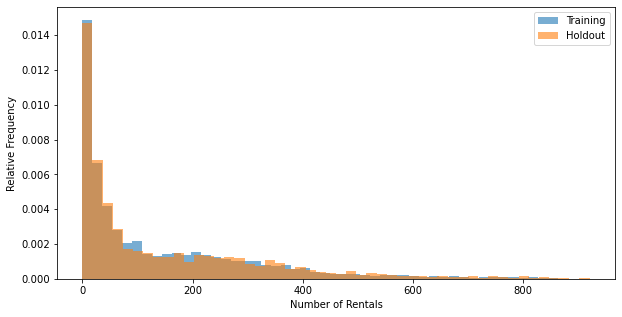

In [17]:
# Plot the distribution of the target variable in the training and holdout sets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.6, label='Training', density= True)
plt.hist(y_test, bins=50, alpha=0.6, label='Holdout', density= True)
plt.xlabel('Number of Rentals')
plt.ylabel('Relative Frequency')
plt.legend()
plt.show()

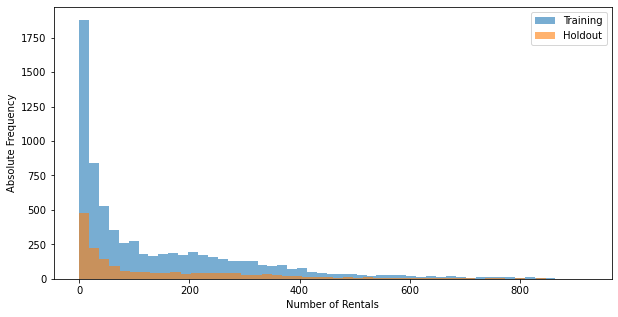

In [18]:
# Plot the distribution of the target variable in the training and holdout sets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.6, label='Training')
plt.hist(y_test, bins=50, alpha=0.6, label='Holdout')
plt.xlabel('Number of Rentals')
plt.ylabel('Absolute Frequency')
plt.legend()
plt.show()

## 4.1 Polynomial Regression

Polynomial regression can model non-linear relationships between the independent and dependent variables, which allows for more flexibility in modeling complex data. This model is using polynomial regression to predict the target variable (bike rentals per hour), based on the selected input features. The input features are standardized, transformed to include polynomial interactions between them, and then passed through a Ridge regression model. Ridge regression includes a regularization term to prevent overfitting. The regularization term is controlled by a parameter called alpha, which determines the strength of the regularization.

The script uses a GridSearchCV object to find the best combination of parameters for the polynomial degree and alpha. The GridSearchCV object is trained on the input data and returns the best combination of parameters that minimize the negative mean squared error. This way, the script finds the best polynomial degree and best Ridge alpha that fits the input data.

The results indicate that the model performing best had a polynomial degree of 7 and a regularization strength of 44.0. The model with these parameters will be the one used for further prediction and evaulation.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Define the pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures()), ('reg', Ridge())])

# Define the parameter grid
param_grid = {'poly__degree': range(1,10), 'reg__alpha': np.linspace(0, 100, num=101)}

# Create a GridSearchCV object
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid.best_params_)

Best parameters:  {'poly__degree': 7, 'reg__alpha': 44.0}


The code is using the trained model to make predictions on the test data set. Then, it calculates three evaluation metrics, namely Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared, which are all commonly used to evaluate the performance of a regression model. The MAE is a measure of how far off the predictions are from the actual values, on average. The MSE is similar to MAE but it penalizes larger errors more heavily. R-squared is a measure of how well the model fits the data, with a value of 1 indicating a perfect fit and a value of 0 indicating that the model does not explain any of the variability in the data. 

The R-squared value of 0.721 tells us that the model explains 72,1% of the variance in the target variable. This means that the model is able to capture a majority of the underlying patterns in the data, but it is not optimal. There may be other factors that are not being considered by the model that are contributing to the remaining 28% of the variance in the target variable.

In [21]:
# Make predictions on the test data
y_pred = grid.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("R-squared: ", r2)

Mean Absolute Error:  57.80740761633213
Mean Squared Error:  8368.803355851454
R-squared:  0.7210054387162408


This code is plotting a scatter plot of the actual target values against the predicted values for both the training and test data. The plot shows how well the model is performing in terms of predicting the target variable. The closer the points on the scatter plot are to the black line, which represents a perfect prediction, the better the model is performing. The two plots, one for the training data and one for the test data, allow to compare the model's performance on both sets of data. 

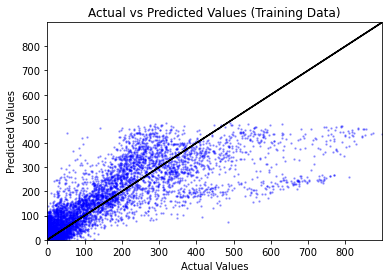

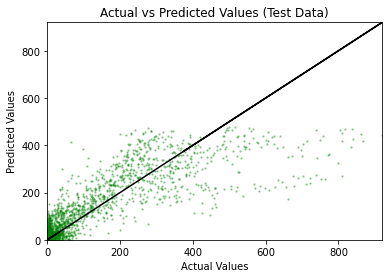

In [28]:
# Use the model to predict the target variable for the training data
predicted_values_train = grid.predict(X_train)

# Use the model to predict the target variable for the test data
predicted_values_test = grid.predict(X_test)

# Plot the actual target values against the predicted values for the training data
plt.scatter(y_train, predicted_values_train, color = "blue", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Training Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_train, y_train, color = "black")
plt.axis([min(y_train), max(y_train), min(y_train), max(y_train)])
plt.show()

# Plot the actual target values against the predicted values for the test data
plt.scatter(y_test, predicted_values_test, color = "green", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Test Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_test, y_test, color = "black")
plt.axis([min(y_test), max(y_test), min(y_test), max(y_test)]) 
plt.show()

The performance of the polynomial model we used was quite good for the start. However, it does have some disadvantages that we should keep in mind. One such disadvantage is that it can be prone to overfitting, where the model becomes too complex and starts fitting the noise in the data. Additionally, it can be sensitive to outliers in the data and can be computationally expensive as the degree of the polynomial increases. To further improve our predictions, we will continue with other models such as Random Forest, Neural Networks, and Gradient Boosting.


## 4.2 Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [2, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters from the search
best_params = random_search.best_estimator_.get_params()
print("Best parameters found: ",best_params)

Best parameters found:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [19]:
# Use the best parameters to create a new model
best_rf_model = RandomForestRegressor(random_state=42, **random_search.best_params_)

# Fit the new model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the holdout set
y_pred = best_rf_model.predict(X_test)

# Evaluate the new model's performance on the holdout set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

Mean Squared Error:  2147.7500762154123
Mean Absolute Error:  26.23946473968073
R-squared:  0.9283358632489239


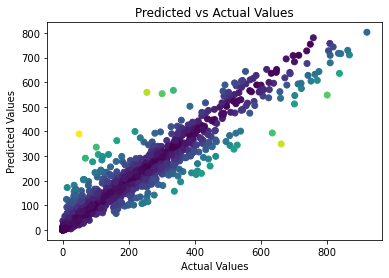

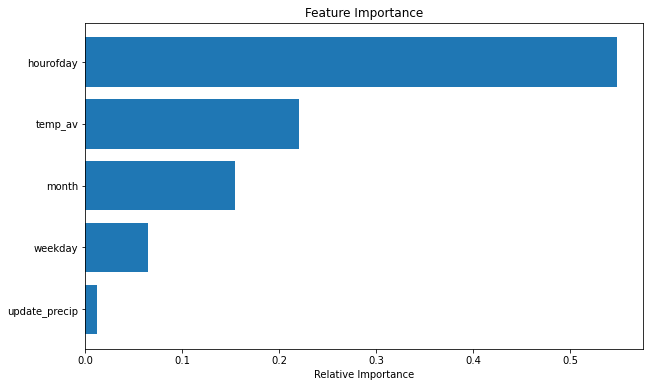

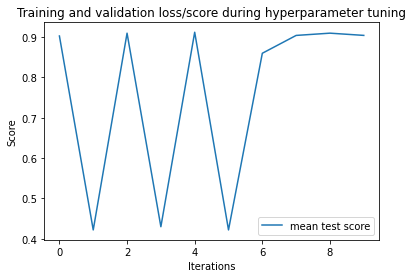

In [20]:
# Create an array of colors based on the difference between the predicted and actual values
colors = np.abs(y_test - y_pred)

# Plot the predicted vs actual values on the holdout set
plt.scatter(y_test, y_pred, c=colors)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Plot the distribution of the feature importances
importances = best_rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

# plot the training and validation loss/score during hyperparameter tuning
plt.plot(random_search.cv_results_['mean_test_score'], label = 'mean test score')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Training and validation loss/score during hyperparameter tuning')
plt.legend()
plt.show()

The metrics indicate that the random forest model is able to predict the number of bike rentals per hour with a relatively high level of accuracy. The Mean Squared Error (MSE) is a measure of how much the model's predictions deviate from the true values, with a lower value indicating a better fit. In this case, the MSE is 2147.75, which suggests that the model's predictions are relatively close to the true values.

The Mean Absolute Error (MAE) is similar to MSE, but it measures the average magnitude of the errors in the model's predictions, without considering their direction. The MAE in this case is 26.23, which suggests that the average magnitude of the errors is relatively low.

The R-squared value is a measure of how much of the variation in the output variable is explained by the model. A value of 1 indicates that the model explains all the variation, while a value of 0 means the model explains none of it. The R-squared value of 0.9283358632489239 indicates that the model explains a large proportion of the variation in the output variable, which is a good indication of model performance.

In summary, the results of the random forest model indicate that the model is able to predict the number of bike rentals per hour with a relatively high level of accuracy, and the MSE, MAE and R-squared values are all good indicators of the model's performance.

## 4.3 Neural Network

First try: The warning message "ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT" is raised because the optimizer used by the neural network (L-BFGS) was not able to find a solution that satisfies the convergence criteria within the maximum number of iterations specified.

Solution: Increase the maximum number of iterations and scale the input features: 'max_iter': [1000, 2000, 5000]

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error:  2909.6630511177023
Mean Absolute Error:  35.0541723838762
R-squared:  0.9029130562703616


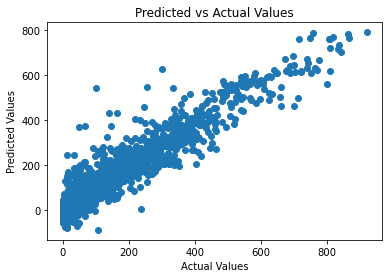

Best parameters found:  {'solver': 'lbfgs', 'max_iter': 2000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'activation': 'relu'}


In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for the MLP model
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (200,)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling'],
    'max_iter': [1000, 2000, 5000]
}

# Create a MLP model
mlp_model = MLPRegressor(random_state=42)

# Use RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(estimator=mlp_model, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Train the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_search.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

# Plot the predicted vs actual values on the test set
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Print the best parameters from the search
best_params = random_search.best_estimator_.get_params()
print("Best parameters found: ",random_search.best_params_)


## 4.4 Gradient Boosting 

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model using the random forest and neural network predictions as input features
X_train_gb = np.column_stack((best_rf_model.predict(X_train), random_search.predict(X_train)))
X_test_gb = np.column_stack((best_rf_model.predict(X_test), random_search.predict(X_test)))

gb_model.fit(X_train_gb, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test_gb)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)


Mean Squared Error:  2725.53845703338
Mean Absolute Error:  32.71461677160589
R-squared:  0.9090567553142218
